## 0. Imports

In [74]:
from src.data.preparation import BookingData
import matplotlib.pyplot as plt
import missingno
import pandas as pd
import seaborn as sns

plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data Exploration

In [40]:
df = BookingData()

In [41]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [42]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


<AxesSubplot:>

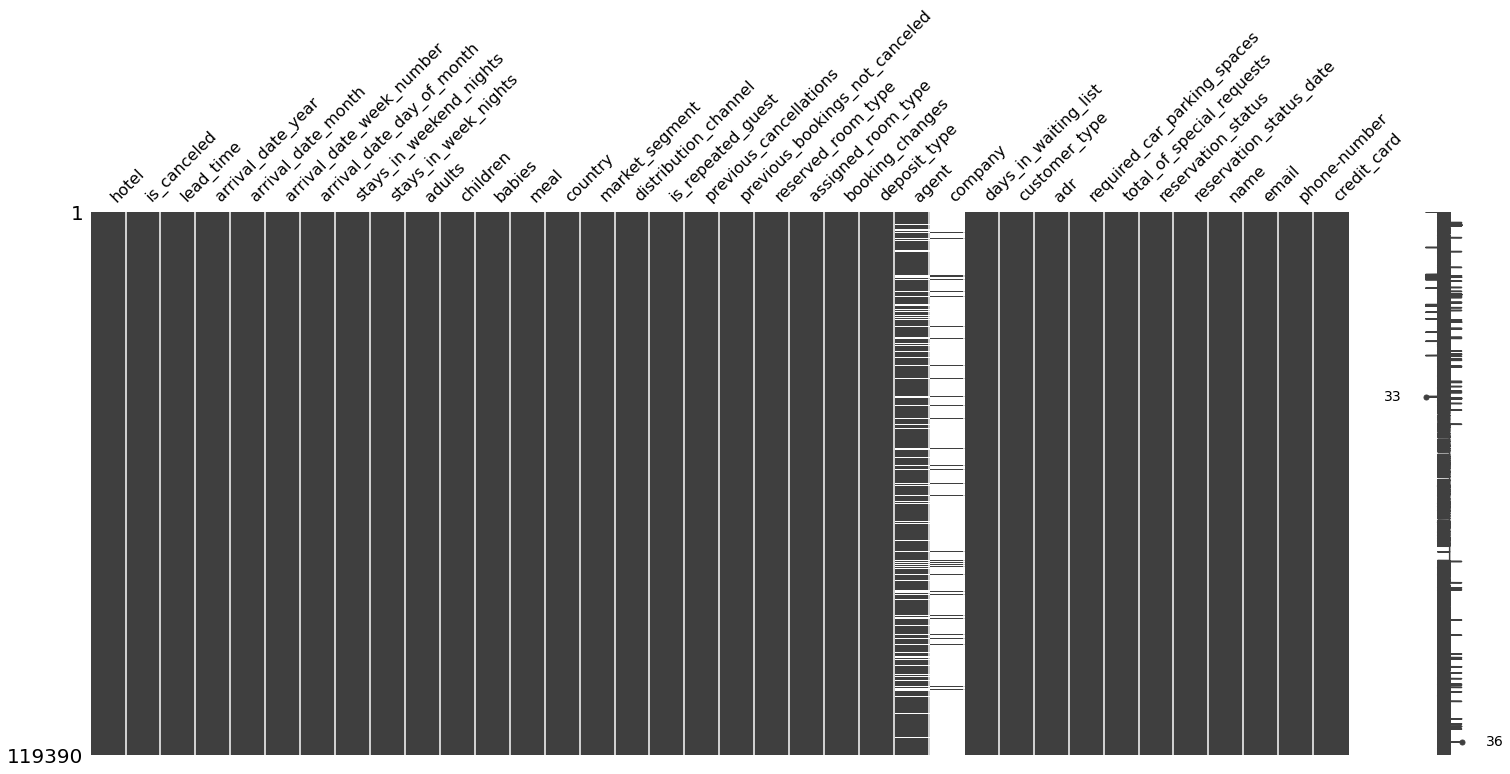

In [46]:
missingno.matrix(df)

## 2. Exploratory Data Analysis

In [47]:
df.prepare()

### 2.1 Correlations

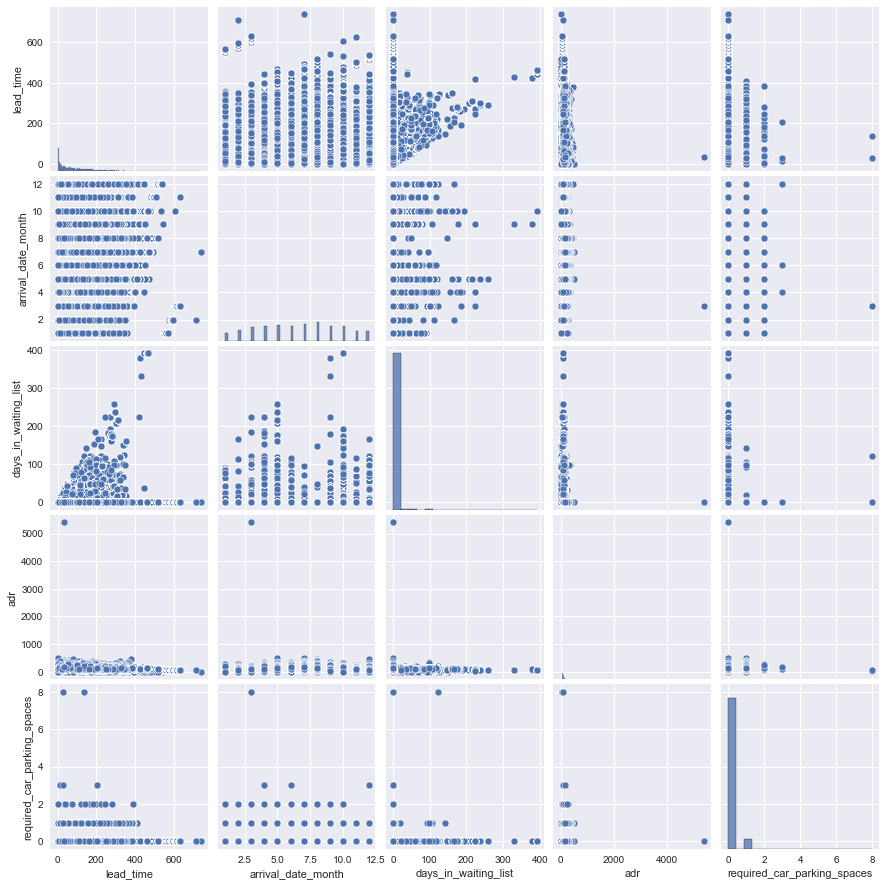

In [104]:
sns.pairplot(data=df[['lead_time', 'arrival_date_month','days_in_waiting_list', 'adr', 'required_car_parking_spaces']])

<AxesSubplot:>

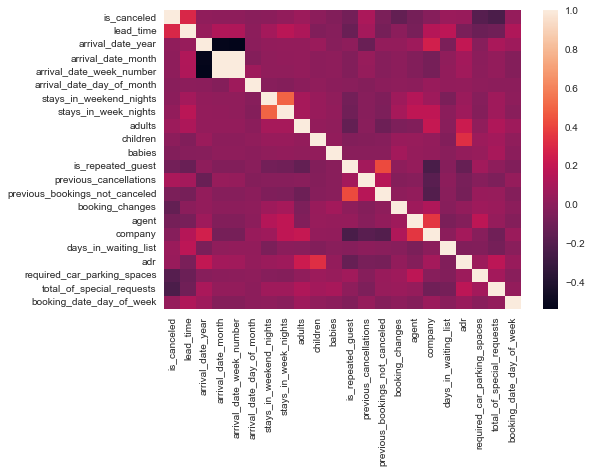

In [98]:
sns.heatmap(df.correlation())

In [68]:
correlations_all = df.correlation()['is_canceled'].sort_values(ascending=False)
correlations_city = df.city.correlation()['is_canceled']
correlations_resort = df.resort.correlation()['is_canceled']
correlations_df = correlations_all.to_frame().rename({'is_canceled': "All"}, axis=1)
correlations_df = correlations_df.join(correlations_city).rename({'is_canceled': "City"}, axis=1)
correlations_df = correlations_df.join(correlations_resort).rename({'is_canceled': "Resort"}, axis=1)
correlations_df

,All,City,Resort
is_canceled,1.000000,1.000000,1.000000
lead_time,0.293177,0.309317,0.229444
previous_cancellations,0.110140,0.166660,0.114173
adults,0.059990,0.053011,0.080546
days_in_waiting_list,0.054193,0.060976,-0.036301
adr,0.047622,-0.011863,0.109317
booking_date_day_of_week,0.034081,0.027885,0.029677
stays_in_week_nights,0.024771,0.048704,0.078477
arrival_date_year,0.016732,-0.002905,0.043624
arrival_date_month,0.011002,0.004018,0.025185


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, 'is_canceled'),
  Text(1, 0, 'lead_time'),
  Text(2, 0, 'previous_cancellations'),
  Text(3, 0, 'adults'),
  Text(4, 0, 'days_in_waiting_list'),
  Text(5, 0, 'adr'),
  Text(6, 0, 'booking_date_day_of_week'),
  Text(7, 0, 'stays_in_week_nights'),
  Text(8, 0, 'arrival_date_year'),
  Text(9, 0, 'arrival_date_month'),
  Text(10, 0, 'arrival_date_week_number'),
  Text(11, 0, 'children'),
  Text(12, 0, 'stays_in_weekend_nights'),
  Text(13, 0, 'arrival_date_day_of_month'),
  Text(14, 0, 'company'),
  Text(15, 0, 'babies'),
  Text(16, 0, 'previous_bookings_not_canceled'),
  Text(17, 0, 'agent'),
  Text(18, 0, 'is_repeated_guest'),
  Text(19, 0, 'booking_changes'),
  Text(20, 0, 'required_car_parking_spaces'),
  Text(21, 0, 'total_of_special_requests')])

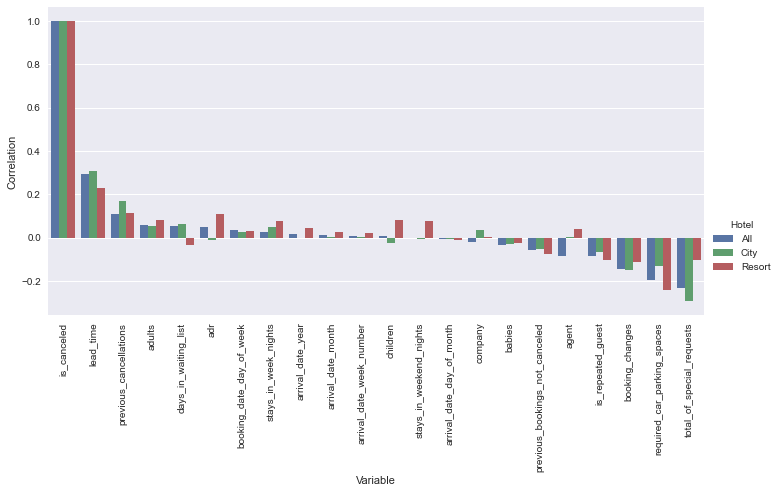

In [92]:
correlations_plot_df = pd.melt(correlations_df, ignore_index=False, var_name="Hotel", value_name="Correlation")
correlations_plot_df['Variable'] = correlations_plot_df.index
sns.catplot(data=correlations_plot_df, kind='bar', x='Variable', y='Correlation', hue='Hotel', aspect=2)
plt.xticks(rotation=90)

### 2.2 Frequency Distributions

array([[<AxesSubplot:title={'center':'is_canceled'}>,
        <AxesSubplot:title={'center':'lead_time'}>,
        <AxesSubplot:title={'center':'arrival_date_year'}>,
        <AxesSubplot:title={'center':'arrival_date_month'}>,
        <AxesSubplot:title={'center':'arrival_date_week_number'}>],
       [<AxesSubplot:title={'center':'arrival_date_day_of_month'}>,
        <AxesSubplot:title={'center':'stays_in_weekend_nights'}>,
        <AxesSubplot:title={'center':'stays_in_week_nights'}>,
        <AxesSubplot:title={'center':'adults'}>,
        <AxesSubplot:title={'center':'children'}>],
       [<AxesSubplot:title={'center':'babies'}>,
        <AxesSubplot:title={'center':'is_repeated_guest'}>,
        <AxesSubplot:title={'center':'previous_cancellations'}>,
        <AxesSubplot:title={'center':'previous_bookings_not_canceled'}>,
        <AxesSubplot:title={'center':'booking_changes'}>],
       [<AxesSubplot:title={'center':'agent'}>,
        <AxesSubplot:title={'center':'company'}>,
   

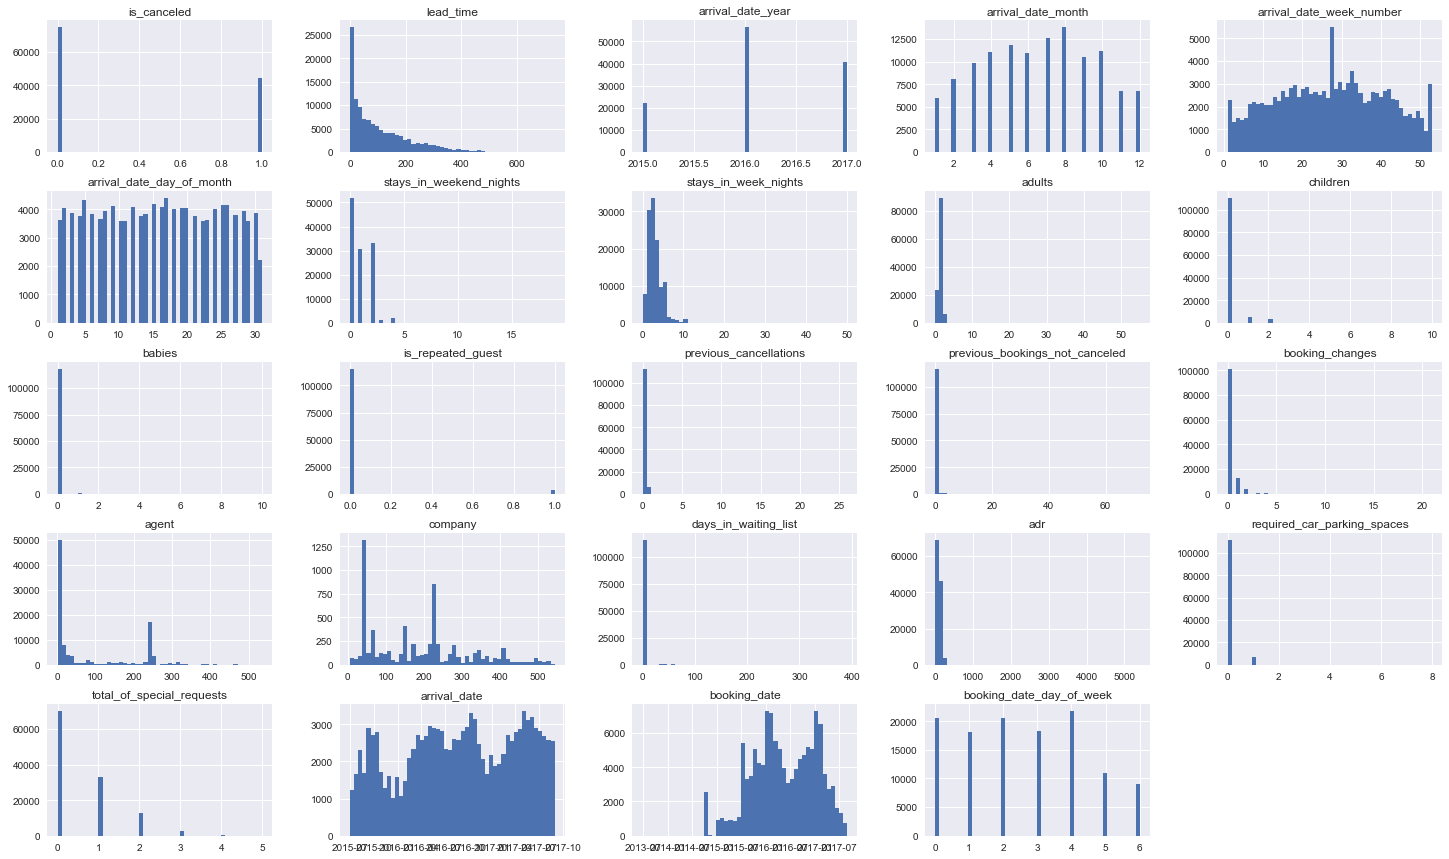

In [107]:
df.hist(bins=50, figsize=(25,15))

<AxesSubplot:xlabel='booking_date_day_of_week', ylabel='Count'>

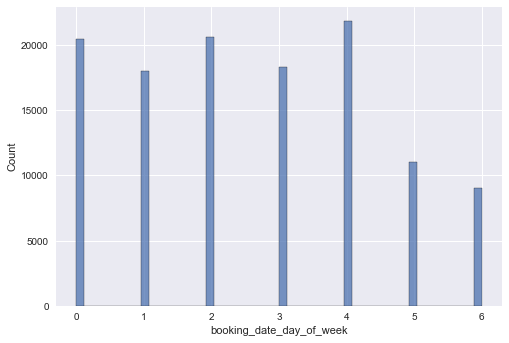

In [93]:
sns.histplot(df['booking_date_day_of_week'])

<AxesSubplot:xlabel='hotel', ylabel='Count'>

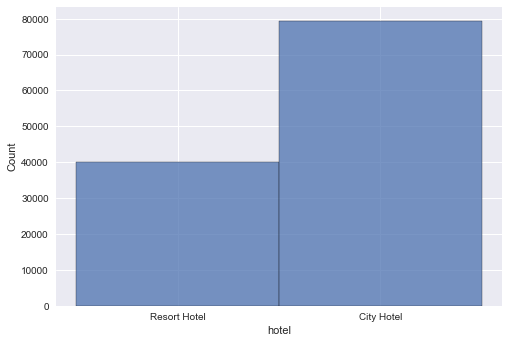

In [94]:
sns.histplot(df['hotel'])

<AxesSubplot:xlabel='lead_time', ylabel='Count'>

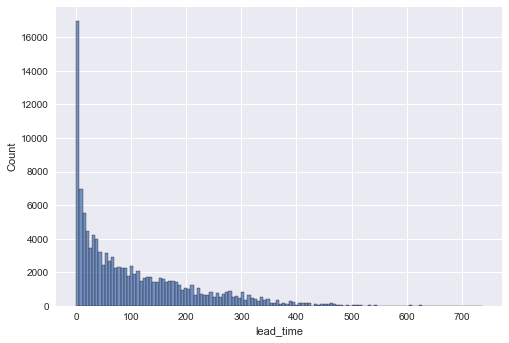

In [96]:
sns.histplot(df['lead_time'])